In [ ]:
pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [1]:
import tensorflow as tf
import os
from google.colab import drive
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np


In [2]:
# Monter Google Drive
drive.mount('/content/drive')

# Définir le répertoire des données
data_dir = '/content/drive/My Drive/Machine_Learning_Data'

Mounted at /content/drive


In [3]:

# Éviter l'erreur OOM en réglant la croissance de la mémoire GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Lister les fichiers dans le répertoire "happy"
os.listdir(os.path.join(data_dir, 'Happy'))

['Happy_1.jpeg',
 'Happy_2.jpeg',
 'Happy_3.jpeg',
 'Happy_4.jpeg',
 'Happy_5.jpeg',
 'Happy_6.jpeg',
 'Happy_7.jpeg',
 'Happy_8.jpeg',
 'Happy_9.jpeg',
 'Happy_10.jpeg',
 'Happy_11.jpeg',
 'Happy_12.jpeg',
 'Happy_13.jpeg',
 'Happy_14.jpeg',
 'Happy_15.jpeg',
 'Happy_16.jpeg',
 'Happy_17.jpeg',
 'Happy_18.jpeg',
 'Happy_19.jpeg',
 'Happy_20.jpeg',
 'Happy_21.jpeg',
 'Happy_22.jpeg',
 'Happy_23.jpeg',
 'Happy_24.jpeg',
 'Happy_25.jpeg',
 'Happy_26.jpeg',
 'Happy_27.jpeg',
 'Happy_28.jpeg',
 'Happy_29.jpeg',
 'Happy_30.jpeg',
 'Happy_31.jpeg',
 'Happy_32.jpeg',
 'Happy_33.jpeg',
 'Happy_34.jpeg',
 'Happy_35.jpeg',
 'Happy_36.jpeg',
 'Happy_37.jpeg',
 'Happy_38.jpeg',
 'Happy_39.jpeg',
 'Happy_40.jpeg',
 'Happy_41.jpeg',
 'Happy_43.jpeg',
 'Happy_44.jpeg',
 'Happy_45.jpeg',
 'Happy_46.jpeg',
 'Happy_47.jpeg',
 'Happy_48.jpeg',
 'Happy_49.jpeg',
 'Happy_50.jpeg',
 'Happy_51.jpeg',
 'Happy_52.jpeg',
 'Happy_53.jpeg',
 'Happy_54.jpeg',
 'Happy_55.jpeg',
 'Happy_56.jpeg',
 'Happy_57.jpeg',
 

In [7]:
# Extensions d'image acceptées
image_exts = ['jpeg', 'jpg', 'bmp', 'png', 'gif']

# Vérifier et afficher les fichiers non valides
invalid_images = []
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        ext = image.split('.')[-1].lower()
        if ext not in image_exts:
            print(f"Image not in ext list: {image_path}")
            invalid_images.append(image_path)
        else:
            try:
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Image could not be read: {image_path}")
                    invalid_images.append(image_path)
                else:
                    # Check if TensorFlow can read the image
                    img = tf.io.read_file(image_path)
                    img = tf.image.decode_image(img)
            except Exception as e:
                print(f"Issue with image {image_path}: {e}")
                invalid_images.append(image_path)

print(f"Found {len(invalid_images)} invalid images:")
for invalid_image in invalid_images:
    print(invalid_image)


Found 0 invalid images:


In [8]:
from PIL import Image
import os

for image_path in invalid_images:
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')  # Convertir en format standard RGB
        img.save(image_path)  # Réenregistrer l'image
        print(f"Image re-saved: {image_path}")
    except Exception as e:
        print(f"Could not re-save image {image_path}: {e}")

In [17]:
# Charger les données en tant que dataset TensorFlow
data = tf.keras.utils.image_dataset_from_directory(data_dir)

# Obtenir un itérateur de données
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 1113 files belonging to 2 classes.


In [10]:
class_names = data.class_names
print(class_names[0])
print(class_names[1])

Happy
Sad


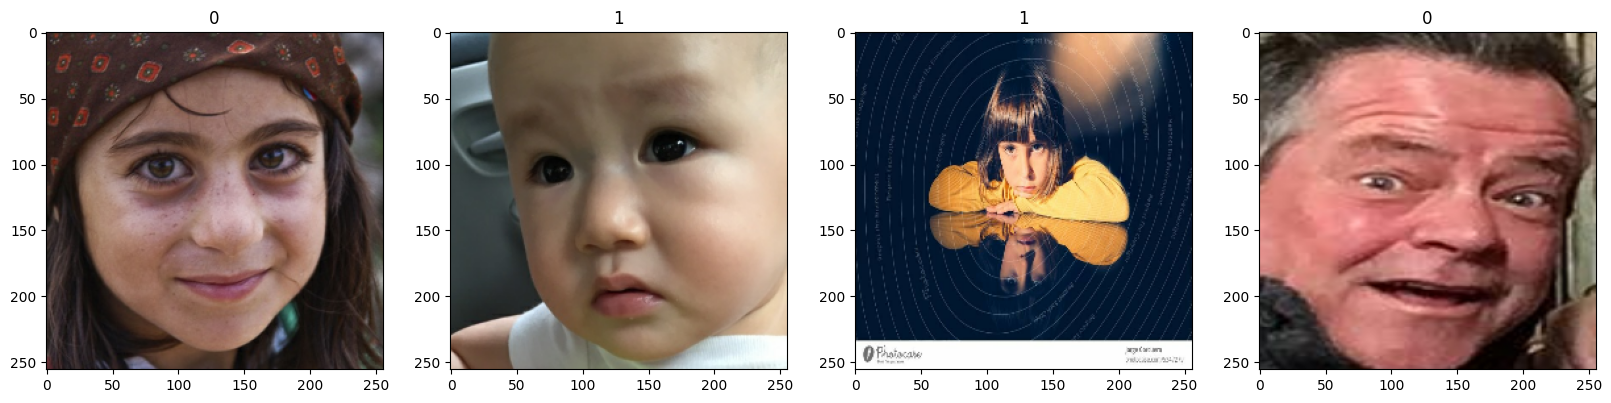

In [18]:
# Afficher quelques images et leurs étiquettes
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [19]:
# Normaliser les données
data = data.map(lambda x, y: (x / 255, y))
data = data.shuffle(buffer_size=len(data))

In [20]:
# Diviser les données en ensembles d'entraînement, de validation et de test
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [28]:
# Définir et compiler le modèle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [29]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
# Enregistrer les logs pour TensorBoard
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
# Entraîner le modèle
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
24/24 [==============================] - 31s 556ms/step - loss: 0.6777 - accuracy: 0.5519 - val_loss: 0.5931 - val_accuracy: 0.7143
Epoch 2/25
24/24 [==============================] - 22s 507ms/step - loss: 0.6197 - accuracy: 0.6754 - val_loss: 0.6182 - val_accuracy: 0.6083
Epoch 3/25
24/24 [==============================] - 23s 564ms/step - loss: 0.5788 - accuracy: 0.6965 - val_loss: 0.5944 - val_accuracy: 0.6820
Epoch 4/25
24/24 [==============================] - 20s 492ms/step - loss: 0.5475 - accuracy: 0.7319 - val_loss: 0.5200 - val_accuracy: 0.7232
Epoch 5/25
24/24 [==============================] - 22s 502ms/step - loss: 0.5366 - accuracy: 0.7422 - val_loss: 0.4957 - val_accuracy: 0.7411
Epoch 6/25
24/24 [==============================] - 20s 467ms/step - loss: 0.5382 - accuracy: 0.7004 - val_loss: 0.4655 - val_accuracy: 0.7545
Epoch 7/25
24/24 [==============================] - 23s 519ms/step - loss: 0.4624 - accuracy: 0.7786 - val_loss: 0.3959 - val_accuracy: 0.8080

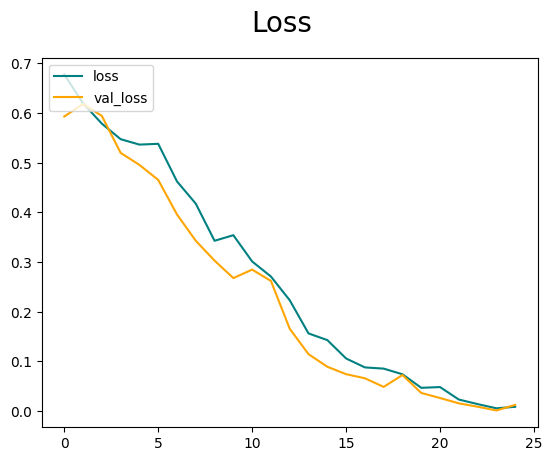

In [33]:

# Afficher les performances
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


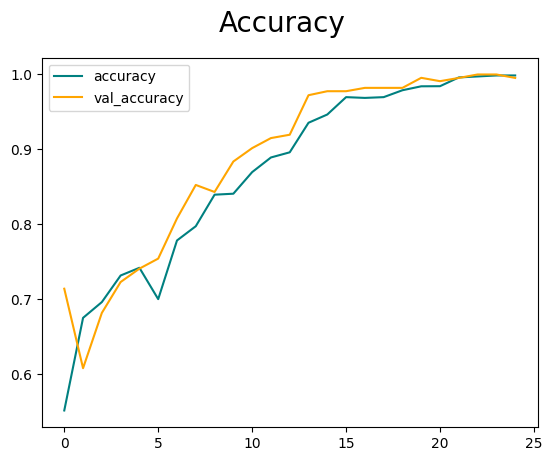

In [34]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import numpy as np

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # Binarisation des prédictions avec un seuil de 0.5
    yhat = np.where(yhat > 0.5, 1, 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')


1/1 [==============================] - 0s 29ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


In [36]:
# Sauvegarder et recharger le modèle
model.save('/content/drive/My Drive/Machine_Learning_Data/happysadModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import cv2
model = tf.keras.models.load_model('/content/drive/My Drive/Machine_Learning_Data/happysadModel.h5')

In [38]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Fonction pour prétraiter une image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalisation
    return np.expand_dims(img, axis=0)  # Ajouter une dimension pour le batch



In [116]:
# Chemin de l'image de test
test_image_path = '/content/drive/My Drive/test_DL/image.jpg'

# Prétraiter l'image
test_image = preprocess_image(test_image_path)

In [117]:

# Faire la prédiction
prediction = model.predict(test_image)
prediction_class = 'Positive' if prediction[0][0] < 0.5 else 'Negative'


1/1 [==============================] - 0s 19ms/step


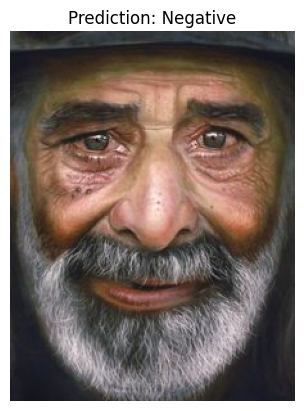

In [118]:

# Afficher l'image et la prédiction
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {prediction_class}')
plt.axis('off')
plt.show()